In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
from matplotlib.lines import Line2D

# set font size
mpl.rcParams.update({'font.size': 8})

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [2]:
nerd_sqlite = '../../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

In [3]:
rg_ids = [123, 124, 129, 130]  # P4P6 rg_ids

query = """
SELECT *
FROM probe_tc_fits_view
WHERE fit_kind = 'round3_constrained'
  AND rg_id IN ({})
  AND rt_protocol = 'MRT'
ORDER BY rg_id
""".format(",".join(["?"] * len(rg_ids)))

df = read_sql(query, params=rg_ids)
conn.close()

In [4]:
import numpy as np

def calculate_dG(logkobs, logkadd):
    R = 1.9872036e-3  # kcal/(mol*K)
    T = 298.15  # K
    
    logKKp1 = logkobs - logkadd
    KKp1 = np.exp(logKKp1) # K / (K+1)
    K = KKp1 / (1 - KKp1)
    dG = -R * T * np.log(K)

    return dG

logkadd = -2.676278119425211 # logkadd
logkobs_r2_99 = -3.4806204679354953
logkobs_r2_55 = -7.240355294404981
logkobs_r2_39 = -7.503658411920693

dG_r2_99 = calculate_dG(logkobs_r2_99, logkadd)
dG_r2_55 = calculate_dG(logkobs_r2_55, logkadd)
dG_r2_39 = calculate_dG(logkobs_r2_39, logkadd)

print(f"dG for r2=0.99: {dG_r2_99:.2f} kcal/mol")
print(f"dG for r2=0.55: {dG_r2_55:.2f} kcal/mol")
print(f"dG for r2=0.39: {dG_r2_39:.2f} kcal/mol")

dG for r2=0.99: 0.13 kcal/mol
dG for r2=0.55: 2.70 kcal/mol
dG for r2=0.39: 2.86 kcal/mol


In [11]:
# get max log_kobs for each nt_base and save in dict
max_logkobs = {}
for base in df['nt_base'].unique():
    df_base = df[df['nt_base'] == base]
    max_logkobs[base] = df_base['log_kobs'].max()
max_logkobs

{'G': -4.967495085381301,
 'A': -2.676278119425211,
 'U': -5.4781295234491605,
 'C': -2.906675137420539}

In [12]:
def calc_dG(logkobs, logkadd):
    R = 1.9872036e-3  # kcal/(mol*K)
    T = 298.15  # K
    
    logKKp1 = logkobs - logkadd
    KKp1 = np.exp(logKKp1) # K / (K+1)
    K = KKp1 / (1 - KKp1)
    dG = -R * T * np.log(K)

    return dG

df['dG'] = df.apply(lambda row: calc_dG(row['log_kobs'], max_logkobs[row['nt_base']]), axis=1)
df

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_16313/66049610.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  K = KKp1 / (1 - KKp1)


,fit_run_id,rg_id,nt_id,fit_kind,rg_label,temperature,probe,probe_conc,rt_protocol,buffer_id,...,nt_site,nt_base,kobs,log_kobs,log_kdeg,log_kobs_err,log_kdeg_err,r2,metadata_json,dG
0,274536,123,797,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,103,G,0.000660,-7.323764,-8.067974,0.296183,0.0,0.487337,"{""base"": ""G"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",1.337060
1,274537,123,798,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,104,A,0.022931,-3.775280,-8.067974,0.039808,0.0,0.981779,"{""base"": ""A"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.411026
2,274538,123,799,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,105,A,0.017473,-4.047125,-8.067974,0.045539,0.0,0.976153,"{""base"": ""A"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.638676
3,274539,123,800,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,106,U,0.000927,-6.983541,-8.067974,0.267403,0.0,0.538394,"{""base"": ""U"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.743259
4,274540,123,801,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,107,U,0.001103,-6.809645,-8.067974,0.144518,0.0,0.799772,"{""base"": ""U"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.607229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,275511,124,939,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,245,G,0.000381,-7.873467,-8.242844,0.577642,0.0,0.374830,"{""base"": ""G"", ""fmod_run_ids"": [44, 45, 46, 47,...",1.688418
412,275516,124,944,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,250,G,0.000255,-8.273244,-8.242844,1.030822,0.0,0.158407,"{""base"": ""G"", ""fmod_run_ids"": [44, 45, 46, 47,...",1.936470
413,275517,124,945,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,251,G,0.000253,-8.280811,-8.242844,1.323388,0.0,0.102497,"{""base"": ""G"", ""fmod_run_ids"": [44, 45, 46, 47,...",1.941123
414,275520,124,948,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,254,G,0.000547,-7.510987,-8.242844,0.923467,0.0,0.190010,"{""base"": ""G"", ""fmod_run_ids"": [44, 45, 46, 47,...",1.458484


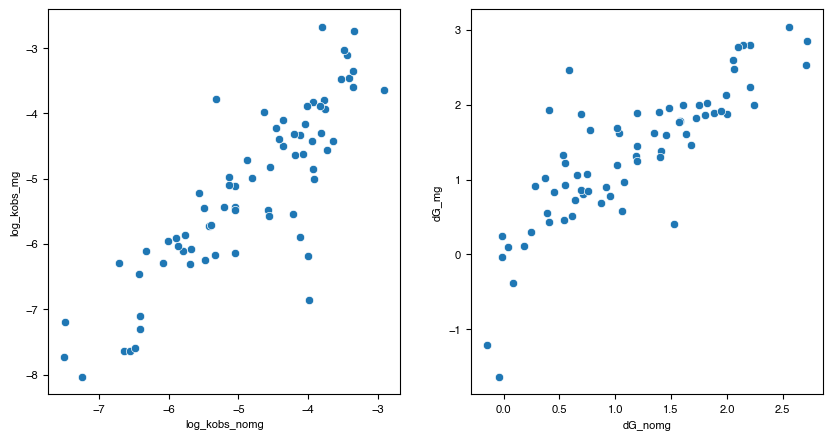

In [13]:
## Analysis of correlation
def keep_higher_r2(df):
    for site in df['nt_site'].unique():
        # drop row with lower r2
        df_site = df[df['nt_site'] == site]
        if len(df_site) != 2:
            continue
        if df_site.iloc[0]['r2'] > df_site.iloc[1]['r2']:
            df = df.drop(df_site.index[1])
        else:
            df = df.drop(df_site.index[0])
    return df

df_nomg = df[df['buffer_id'] == 2]
df_nomg = keep_higher_r2(df_nomg)
df_mg = df[df['buffer_id'] == 3]
df_mg = keep_higher_r2(df_mg)
df_mg

# merge df_nomg and df_mg on nt_site and keep the following: nt_site, nt_base, log_kobs, log_kobs_err, dG, r2
# add suffix to all but nt_site and nt_base
df_merged = pd.merge(df_nomg[['nt_site', 'nt_base', 'log_kobs', 'log_kobs_err', 'dG', 'r2']],
                     df_mg[['nt_site', 'log_kobs', 'log_kobs_err', 'dG', 'r2']],
                     on=['nt_site'],
                     suffixes=('_nomg', '_mg'))

# filter to A and C only
df_merged_AC = df_merged[df_merged['nt_base'].isin(['A', 'C'])]

# filter to R2 > 0
df_merged_AC = df_merged_AC[(df_merged_AC['r2_nomg'] > 0.3) & (df_merged_AC['r2_mg'] > 0.3)]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=df_merged_AC, x='log_kobs_nomg', y='log_kobs_mg', ax=axs[0])
sns.scatterplot(data=df_merged_AC, x='dG_nomg', y='dG_mg', ax=axs[1])
plt.show()

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Fit linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_merged_AC['log_kobs_nomg'],
    df_merged_AC['log_kobs_mg']
)

# Predicted y-values
x = df_merged_AC['log_kobs_nomg']
y_pred = intercept + slope * x

# Residuals
residuals = df_merged_AC['log_kobs_mg'] - y_pred

# Standard deviation of residuals (σ)
sigma = residuals.std()

# R2 value
r2 = r_value**2
r2

slope, intercept, sigma

(0.9923045687513479, -0.35318668004097464, 0.6738925660204269)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


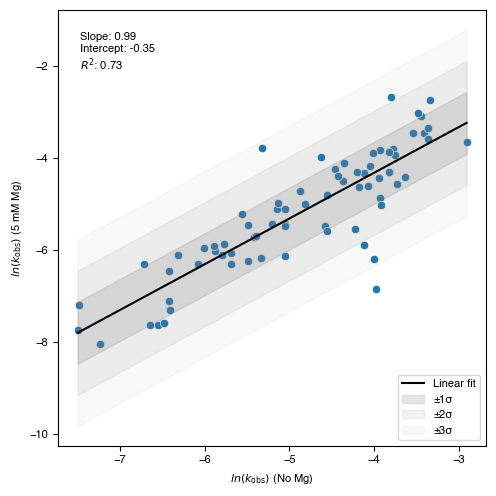

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    data=df_merged_AC,
    x='log_kobs_nomg',
    y='log_kobs_mg',
    ax=ax
)

# Regression line
x_line = np.linspace(x.min(), x.max(), 200)
y_line = intercept + slope * x_line
ax.plot(x_line, y_line, color='black', label='Linear fit')

# ±1σ band
ax.fill_between(
    x_line,
    y_line - sigma,
    y_line + sigma,
    color='gray',
    alpha=0.2,
    label='±1σ'
)

# ±2σ band
ax.fill_between(
    x_line,
    y_line - 2*sigma,
    y_line + 2*sigma,
    color='gray',
    alpha=0.1,
    label='±2σ'
)

# ±3σ band
ax.fill_between(
    x_line,
    y_line - 3*sigma,
    y_line + 3*sigma,
    color='gray',
    alpha=0.05,
    label='±3σ'
)

ax.set_xlabel(r'$ln(k_{\text{obs}})$ (No Mg)')
ax.set_ylabel(r'$ln(k_{\text{obs}})$ (5 mM Mg)')

# annotate slope, intercept, r2
ax.text(
    0.05, 0.95,
    f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\n$R^2$: {r2:.2f}',
    transform=ax.transAxes,
    verticalalignment='top'
    )

# legend bottom right
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig("log_kobs_nomg_v_log_kobs_mg_p4p6_AC.pdf")
plt.show()

In [16]:
# residuals
df_merged_AC['residual'] = df_merged_AC['log_kobs_mg'] - y_pred

# absolute residual distance
df_merged_AC['abs_residual'] = df_merged_AC['residual'].abs()

# classification
df_merged_AC['sigma_class'] = np.where(
    df_merged_AC['abs_residual'] <= sigma, 'within_1sigma',
    np.where(
        df_merged_AC['abs_residual'] <= 2*sigma, 'within_2sigma',
        'outside_2sigma'
    )
)
df_merged_AC.to_csv("log_kobs_nomg_v_log_kobs_mg_p4p6_AC_with_residuals.csv", index=False)

In [18]:
df_within_1sigma = df_merged_AC[df_merged_AC['sigma_class'] == 'within_1sigma']
df_within_2sigma = df_merged_AC[df_merged_AC['sigma_class'] == 'within_2sigma']
df_outside_2sigma = df_merged_AC[df_merged_AC['sigma_class'] == 'outside_2sigma']

In [19]:
# dG version

df_merged_AC_dG = df_merged_AC.dropna(subset=['dG_nomg', 'dG_mg'])
bad = ~np.isfinite(df_merged_AC_dG['dG_nomg']) | ~np.isfinite(df_merged_AC_dG['dG_mg'])
df_merged_AC_dG = df_merged_AC_dG[~bad]  # or drop/clean those rows

# Fit linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_merged_AC_dG['dG_nomg'],
    df_merged_AC_dG['dG_mg']
)

slope, intercept, sigma

(1.027563253747637, 0.15695071702055907, 0.6738925660204269)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


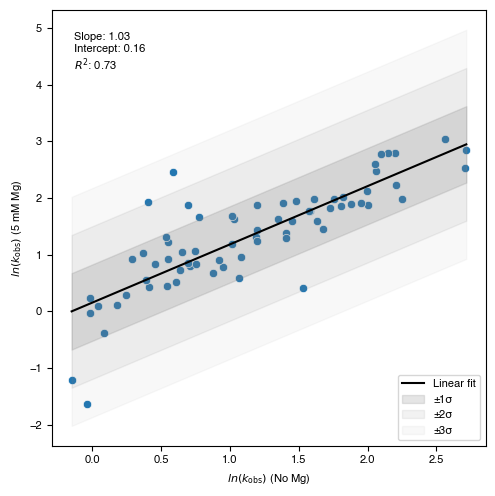

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    data=df_merged_AC_dG,
    x='dG_nomg',
    y='dG_mg',
    ax=ax
)

# Regression line
x_line = np.linspace(df_merged_AC_dG['dG_nomg'].min(), df_merged_AC_dG['dG_nomg'].max(), 200)
y_line = intercept + slope * x_line
ax.plot(x_line, y_line, color='black', label='Linear fit')

# ±1σ band
ax.fill_between(
    x_line,
    y_line - sigma,
    y_line + sigma,
    color='gray',
    alpha=0.2,
    label='±1σ'
)

# ±2σ band
ax.fill_between(
    x_line,
    y_line - 2*sigma,
    y_line + 2*sigma,
    color='gray',
    alpha=0.1,
    label='±2σ'
)

# ±3σ band
ax.fill_between(
    x_line,
    y_line - 3*sigma,
    y_line + 3*sigma,
    color='gray',
    alpha=0.05,
    label='±3σ'
)

ax.set_xlabel(r'$ln(k_{\text{obs}})$ (No Mg)')
ax.set_ylabel(r'$ln(k_{\text{obs}})$ (5 mM Mg)')

# annotate slope, intercept, r2
ax.text(
    0.05, 0.95,
    f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\n$R^2$: {r2:.2f}',
    transform=ax.transAxes,
    verticalalignment='top'
    )

# legend bottom right
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig("dG_nomg_v_dG_mg_p4p6_AC.pdf")
plt.show()

In [22]:
y_pred = intercept + slope * df_merged_AC_dG['dG_nomg']

# residuals
df_merged_AC_dG['residual'] = df_merged_AC_dG['dG_mg'] - y_pred

# absolute residual distance
df_merged_AC_dG['abs_residual'] = df_merged_AC_dG['residual'].abs()

# classification
df_merged_AC_dG['sigma_class'] = np.where(
    df_merged_AC_dG['abs_residual'] <= sigma, 'within_1sigma',
    np.where(
        df_merged_AC_dG['abs_residual'] <= 2*sigma, 'within_2sigma',
        'outside_2sigma'
    )
)
df_merged_AC_dG.to_csv("dG_nomg_v_dG_mg_p4p6_AC_with_residuals.csv", index=False)

<Axes: >

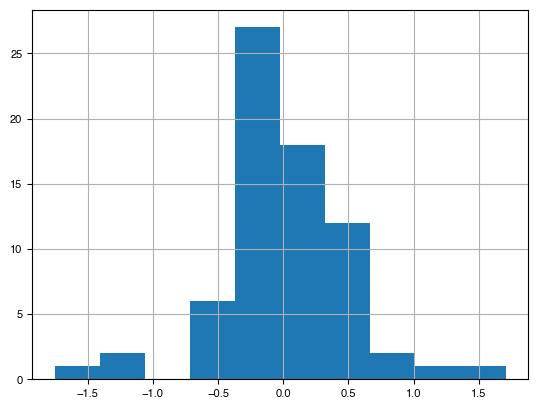

In [23]:
df_merged_AC_dG['residual'].hist()

In [24]:
# filter to within 1 sigma
df_within_1sigma = df_merged_AC_dG[df_merged_AC_dG['sigma_class'] == 'within_1sigma']

# linear regression on within 1 sigma
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_within_1sigma['dG_nomg'],
    df_within_1sigma['dG_mg']
)

# Predicted y-values
x = df_merged_AC_dG['log_kobs_nomg']
y_pred = intercept + slope * x

# Residuals
residuals = df_merged_AC_dG['log_kobs_mg'] - y_pred

# Standard deviation of residuals (σ)
sigma = residuals.std()

# R2 value
r2 = r_value**2

slope, intercept, sigma

(1.0138996095632256, 0.16580996290225403, 0.6596761921561437)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


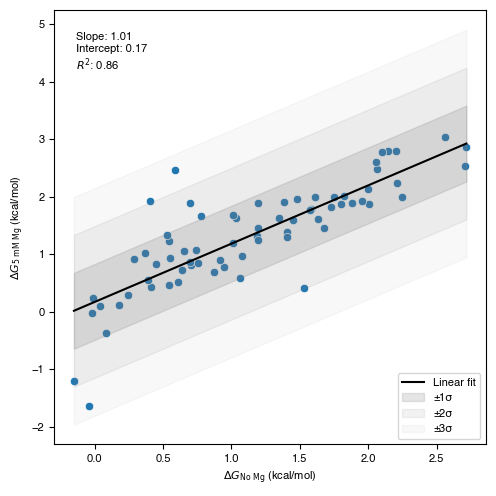

In [25]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    data=df_merged_AC_dG,
    x='dG_nomg',
    y='dG_mg',
    ax=ax
)

# Regression line
x_line = np.linspace(df_merged_AC_dG['dG_nomg'].min(), df_merged_AC_dG['dG_nomg'].max(), 200)
y_line = intercept + slope * x_line
ax.plot(x_line, y_line, color='black', label='Linear fit')

# ±1σ band
ax.fill_between(
    x_line,
    y_line - sigma,
    y_line + sigma,
    color='gray',
    alpha=0.2,
    label='±1σ'
)

# ±2σ band
ax.fill_between(
    x_line,
    y_line - 2*sigma,
    y_line + 2*sigma,
    color='gray',
    alpha=0.1,
    label='±2σ'
)

# ±3σ band
ax.fill_between(
    x_line,
    y_line - 3*sigma,
    y_line + 3*sigma,
    color='gray',
    alpha=0.05,
    label='±3σ'
)

ax.set_xlabel(r'$\Delta G_{\text{No Mg}}$ (kcal/mol)')
ax.set_ylabel(r'$\Delta G_{\text{5 mM Mg}}$ (kcal/mol)')

# annotate slope, intercept, r2
ax.text(
    0.05, 0.95,
    f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\n$R^2$: {r2:.2f}',
    transform=ax.transAxes,
    verticalalignment='top'
    )

# legend bottom right
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig("dG_nomg_v_dG_mg_p4p6_AC_1sigma.pdf")
plt.show()

In [ ]:
# decision tree

In [ ]:
# calculate classifier
df_canonical_annot = pd.read_csv("exports/dG_nomg_v_dG_mg_p4p6_AC_with_residuals_canonical_annot.csv")
df_canonical_annot

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=1)
clf.fit(df_canonical_annot[['abs_residual']], df_canonical_annot['canonical'])

threshold = clf.tree_.threshold[0]
threshold

In [ ]:
df_canonical_annot['canonical'].sum() / len(df_canonical_annot)

In [ ]:
df_canonical_annot[df_canonical_annot['abs_residual'] <= threshold]['canonical'].sum() / 54

In [ ]:
df_canonical = df_canonical_annot[df_canonical_annot['canonical'] == 1]

In [ ]:
df_threshold = df_canonical_annot[df_canonical_annot['abs_residual'] <= threshold]
df_threshold

In [ ]:
sigma

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    data=df_merged_AC_dG,
    x='dG_nomg',
    y='dG_mg',
    ax=ax
)

# plot threshold scatter points in different color
sns.scatterplot(
    data=df_canonical,
    x='dG_nomg',
    y='dG_mg',
    ax=ax, color='red',
    label='Canonical WCF'
)

# Regression line
x_line = np.linspace(df_merged_AC_dG['dG_nomg'].min(), df_merged_AC_dG['dG_nomg'].max(), 200)
y_line = intercept + slope * x_line
ax.plot(x_line, y_line, color='black', label='Linear fit')

# ±1σ band
ax.fill_between(
    x_line,
    y_line - threshold,
    y_line + threshold,
    color='red',
    alpha=0.1,
    label='calc. threshold'
)


# ±1σ band
ax.fill_between(
    x_line,
    y_line - sigma,
    y_line + sigma,
    color='gray',
    alpha=0.2,
    label='±1σ'
)

# ±2σ band
ax.fill_between(
    x_line,
    y_line - 2*sigma,
    y_line + 2*sigma,
    color='gray',
    alpha=0.1,
    label='±2σ'
)

# ±3σ band
ax.fill_between(
    x_line,
    y_line - 3*sigma,
    y_line + 3*sigma,
    color='gray',
    alpha=0.05,
    label='±3σ'
)


ax.set_xlabel(r'$\Delta G_{\text{No Mg}}$ (kcal/mol)')
ax.set_ylabel(r'$\Delta G_{\text{5 mM Mg}}$ (kcal/mol)')

# annotate slope, intercept, r2
ax.text(
    0.05, 0.95,
    f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\n$R^2$: {r2:.2f}',
    transform=ax.transAxes,
    verticalalignment='top'
    )

# legend bottom right
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig("exports/dG_nomg_v_dG_mg_p4p6_AC_1sigma_calc.pdf")
plt.show()